In [2]:
#Setting all the input variables

storm_name = "dorian"
storm_year = 2019
storm_lowerLat= 40

latExtension = 2
lonExtension = 2
dateExtension = 2

focus_variable = "wind_spd_avg"
var_units = "(m s-1)"

In [3]:
# Getting storm data and matching ERDDAP datasets around the storm (time and space)

import tropycal.tracks as tracks
import pandas as pd
from erddapy import ERDDAP
from datetime import timedelta

basin = tracks.TrackDataset(basin='north_atlantic', source='ibtracs')
storm = basin.get_storm((storm_name,storm_year))

# Coordinate selector throws an error when using with Fiona but still generates the graph
storm = storm.sel(lat=[storm_lowerLat,None])

storm_df = storm.to_dataframe()

min_lat = storm_df['lat'].min()
min_lon = storm_df['lon'].min()
max_lat = storm_df['lat'].max()
max_lon = storm_df['lon'].max()
start_date = storm_df.min()['date']
end_date = storm_df.max()['date']

# Get datasets matching time and location criteria, plus a buffer zone

e = ERDDAP(
    server="https://cioosatlantic.ca/erddap", 
    protocol="tabledap",
    response="csv"
)

e.dataset_id = "allDatasets"

e.variables = [
    "datasetID",
    "minLongitude",
    "maxLongitude",
    "minLatitude",
    "maxLatitude",
    "minTime",
    "maxTime"
]

e.constraints = {
    "minTime<=": end_date + timedelta(days = dateExtension),
    "maxTime>=": start_date- timedelta(days = dateExtension),
    "minLatitude>=": min_lat - latExtension,
    "maxLatitude<=": max_lat + latExtension,
    "minLongitude>=": min_lon - lonExtension,
    "maxLongitude<=": max_lon + lonExtension,
}

datasets_df = e.to_pandas(
    parse_dates=True,
).dropna()
datasets = set(datasets_df["datasetID"])

--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (9.69 seconds)
Using no lon bounds


In [4]:
# Narrow down datasets that contain the focused variable
# Some datasets may not match at certain points if their coverage is inconsistent

matching_datasets = []
for dataset in datasets:
    info_url = e.get_info_url(dataset_id = dataset, response = "csv")
    dataset_info = pd.read_csv(info_url)

    variable_names = set(dataset_info["Variable Name"].unique())
    if focus_variable in variable_names:
         matching_datasets.append(dataset)

print(matching_datasets)

['SMA_halifax_anemometer1', 'DFO_Sutron_KLUMI', 'sma_negl_cartwright_junction_nlqu0004', 'SMA_saint_john', 'SMA_port_aux_basques', 'cna_werc_weather_10-min_avg', 'SMA_Holyrood_Buoy2', 'SMA_Fortune_Bay_Buoy', 'SMA_port_aux_basqes_wharf', 'SMA_red_island_shoal', 'SMA_saint_john_cruise_terminal', 'SMA_halifax_pier9c', 'SMA_holyrood_wharf', 'sma_negl_north_west_river_nlqu0007', 'SMA_saint_john_wharf', 'sma_negl_red_bay_nlqu0005', 'SMA_halifax', 'sma_negl_black_tickle_nlqu0003', 'SMA_MouthofPlacentiaBayBuoy', 'SMA_halifax_fairview']


In [5]:
# Find most recent values for focus var given a time point

selected_time=  start_date + timedelta(days = 1)
matching_points = pd.DataFrame()

e = ERDDAP(
    server="https://cioosatlantic.ca/erddap", 
    protocol="tabledap",
    response="csv",
)

for dataset in matching_datasets:

    e.dataset_id = dataset
    print(dataset)
    
    e.constraints = {
        "time<=": selected_time,
        "time>=": selected_time - timedelta(hours = 6)
    }
        
    e.variables = ["time", "longitude", "latitude", focus_variable]

    try:
        buoy_data= e.to_pandas(
            parse_dates=True,
        ).dropna()
        recent_row = buoy_data.tail(1)
        print(recent_row["time (UTC)"].iloc[0])
        print(recent_row[focus_variable + " " + var_units].iloc[0])
        matching_points = pd.concat([matching_points, recent_row.loc[:]]).reset_index(drop=True)
    except:
        print("couldn't find info for the given dataset")
    print("-")


SMA_halifax_anemometer1
couldn't find info for the given dataset
-
DFO_Sutron_KLUMI
couldn't find info for the given dataset
-
sma_negl_cartwright_junction_nlqu0004
2019-09-08T11:52:00Z
7.25
-
SMA_saint_john
2019-09-08T11:53:01Z
8.0
-
SMA_port_aux_basques
2019-09-08T11:54:01Z
21.2
-
cna_werc_weather_10-min_avg
2019-09-08T12:00:00Z
couldn't find info for the given dataset
-
SMA_Holyrood_Buoy2
2019-09-08T11:53:00Z
13.1
-
SMA_Fortune_Bay_Buoy
2019-09-08T11:53:41Z
11.9
-
SMA_port_aux_basqes_wharf
2019-09-08T11:59:15Z
8.3
-
SMA_red_island_shoal
2019-09-08T11:55:00Z
14.1
-
SMA_saint_john_cruise_terminal
2019-09-08T12:00:00Z
5.2
-
SMA_halifax_pier9c
couldn't find info for the given dataset
-
SMA_holyrood_wharf
2019-09-08T11:51:45Z
4.3
-
sma_negl_north_west_river_nlqu0007
2019-09-08T11:16:00Z
3.75
-
SMA_saint_john_wharf
2019-09-08T11:59:36Z
6.1
-
sma_negl_red_bay_nlqu0005
2019-09-08T11:52:00Z
14.25
-
SMA_halifax
2019-09-08T11:53:01Z
7.8
-
sma_negl_black_tickle_nlqu0003
2019-09-08T11:52:00Z
10.

              time (UTC)  longitude (degrees_east)  latitude (degrees_north)  \
0   2019-09-08T11:52:00Z                -58.453140                 52.719830   
1   2019-09-08T11:53:01Z                -66.113767                 45.197167   
2   2019-09-08T11:54:01Z                -59.100398                 47.562842   
3   2019-09-08T11:53:00Z                -53.108107                 47.461835   
4   2019-09-08T11:53:41Z                -55.498453                 47.260857   
5   2019-09-08T11:59:15Z                -59.139467                 47.574533   
6   2019-09-08T11:55:00Z                -54.122208                 47.318377   
7   2019-09-08T12:00:00Z                -66.061167                 45.266833   
8   2019-09-08T11:51:45Z                -53.134950                 47.388657   
9   2019-09-08T11:16:00Z                -60.149180                 53.537400   
10  2019-09-08T11:59:36Z                -66.045167                 45.268867   
11  2019-09-08T11:52:00Z                

<AxesSubplot: xlabel='longitude (degrees_east)', ylabel='latitude (degrees_north)'>

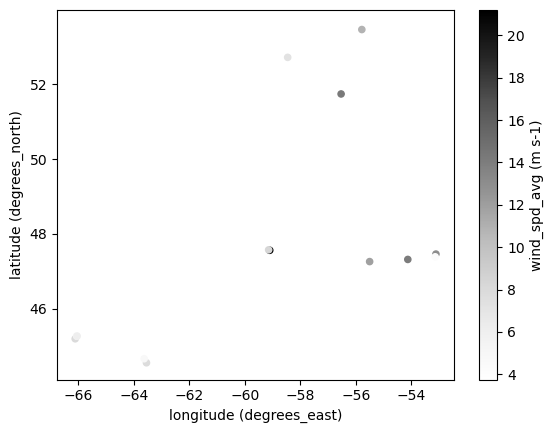

In [12]:
import matplotlib.pyplot as plt

print(matching_points)

matching_points.plot(kind='scatter', x='longitude (degrees_east)', y='latitude (degrees_north)', c='wind_spd_avg (m s-1)', colormap = 'viridis')

In [ ]:
# Create plots  for matching datasets
e = ERDDAP(
    server="https://cioosatlantic.ca/erddap", 
    protocol="tabledap",
    response="csv",
)

for dataset in matching_datasets:

    # Still keeps generating graph after dataset fails for some reason?

    e.dataset_id = dataset

    e.constraints = {
        "time>=": start_date - timedelta(days = 2),
        "time<=": end_date + timedelta(days = 2)
    }

    e.variables = ["time", "longitude", "latitude", focus_variable]

    try:
        buoy_data= e.to_pandas(
            parse_dates=True,
        ).dropna()
        buoy_data.plot(x='time (UTC)', y=focus_variable + ' ' + var_units, title=dataset)
    except:
        print("Data does not exist for %s", dataset) 
